### **Initialize**

In [1]:
# mount to google drive (run from google colab)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# import libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, cv2
import os, multiprocessing, torch, torchvision, torchsummary, gc, random
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from PIL import Image

print('Libraries is Ready!')

Libraries is Ready!


In [3]:
# set up the seed for the random number generator
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
# check libraries version
print(f'np          : {np.__version__}')
print(f'pd          : {pd.__version__}')
print(f'torch       : {torch.__version__}')
print(f'torchvision : {torchvision.__version__}')

np          : 1.26.4
pd          : 2.1.4
torch       : 2.4.1+cu121
torchvision : 0.19.1+cu121


In [39]:
# init constant variable
SHAPE = (728, 728)
DATASET_PATH = 'drive/MyDrive/Colab Notebooks/data/Covid19-dataset'
CORE = multiprocessing.cpu_count() // 2

DISPLAY_ROW = 4
DISPLAY_COL = 8

EPOCHS = 15
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Covid', 'Normal', 'Viral Pneumonia']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Explore Dataset**

In [6]:
# display dataset directory Structure
images, labels, idx_sets = [], [], {}
for i, subdir in enumerate(os.listdir(DATASET_PATH)):
  subdir_path = os.path.join(DATASET_PATH, subdir)
  labels.append(os.listdir(subdir_path))
  images.append([os.listdir(os.path.join(subdir_path, label)) for label in labels[i]])
  total_images = [len(_) for _ in images[i]]
  idx_sets[subdir] = i
  print(f'{subdir}[{i}] : {sorted(zip(labels[i], total_images))}')

test[0] : [('Covid', 26), ('Normal', 20), ('Viral Pneumonia', 20)]
train[1] : [('Covid', 111), ('Normal', 70), ('Viral Pneumonia', 70)]


In [7]:
# check images and labels data from train set
df = pd.DataFrame(images[1][:])
df = df.transpose()
df.columns = labels[1]
df.head()

,Covid,Viral Pneumonia,Normal
0,010.png,031.jpeg,012.jpeg
1,019.png,012.jpeg,010.jpeg
2,012.jpeg,044.jpeg,014.jpeg
3,015.jpg,023.jpeg,019.jpeg
4,02.jpeg,045.jpeg,018.jpeg


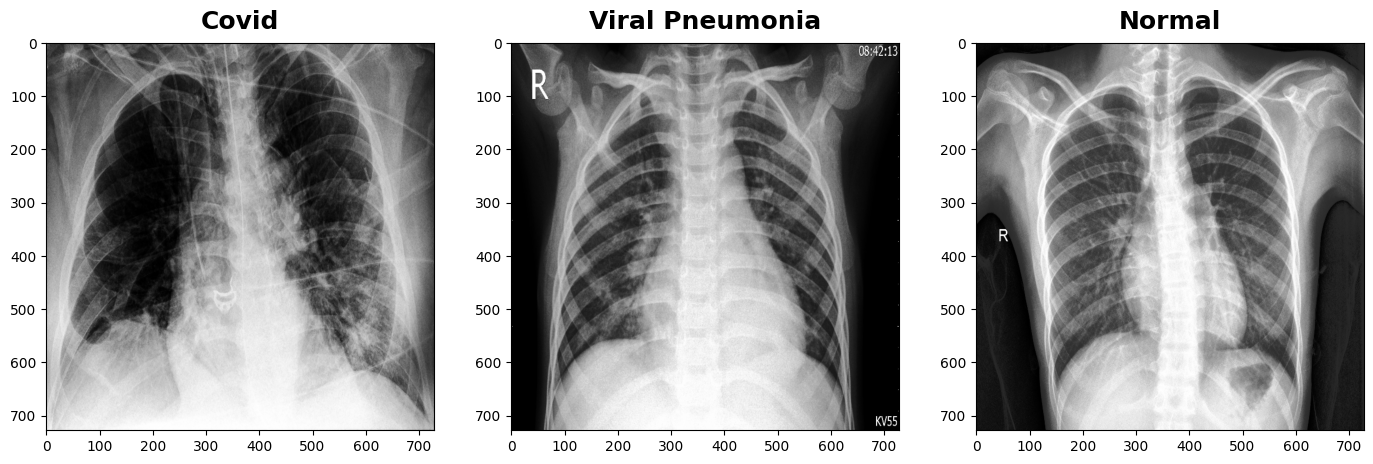

In [8]:
# check each images in train data
plt.figure(figsize=(17, 7))
for i in range(3):
  image_path = os.path.join(DATASET_PATH, 'train', labels[idx_sets['train']][i], images[idx_sets['train']][i][10])
  plt.subplot(1, 3, i+1)
  plt.imshow(cv2.resize(cv2.imread(image_path), SHAPE))
  plt.title(labels[1][i], pad=10, fontsize=18, fontweight='bold')
plt.show()

### **Load Dataset**

In [9]:
# define class DatasetHandler
class DatasetHandler:
  transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(SHAPE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

  def load_image(self, image_path):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image_tensor = self.transformation(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    return torch.autograd.Variable(image_tensor)

  def load_dataset(self):
    train_dataset = torchvision.datasets.ImageFolder(root=f'{DATASET_PATH}/train', transform=self.transformation)
    test_dataset = torchvision.datasets.ImageFolder(root=f'{DATASET_PATH}/test', transform=self.transformation)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=CORE)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=CORE)

    return train_loader, test_loader

  @staticmethod
  def img_show(suptitle, images, label_names, label_ground_truth, label_prediction=None):
    plt.figure(figsize=(19, 11))
    plt.suptitle(suptitle, fontsize=15, fontweight='bold', y=0.92)

    for i in range(BATCH_SIZE):
      image = images[i].numpy().transpose((1, 2, 0))
      image_unnormalized = image * 0.5 + 0.5

      plt.subplot(DISPLAY_ROW, DISPLAY_COL, i+1)
      plt.imshow(image_unnormalized)

      title = label_names[label_ground_truth[i]] + f' [{label_ground_truth[i]}]'
      if label_prediction: title += f'\nPredict: {label_names[label_prediction[i]]}'
      plt.title(title, fontsize=8, pad=10, fontweight='bold')

In [10]:
# load dataset
datasetHandler = DatasetHandler()
train_loader, test_loader = datasetHandler.load_dataset()
print('Load Data Successfully!')

Load Data Successfully!


In [11]:
# check train_loader with dataframe
df_train = pd.DataFrame(train_loader.dataset.imgs, columns=['images_path', 'labels'])
print(f'train shape: {df_train.shape}')
df_train.head()

train shape: (251, 2)


,images_path,labels
0,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
1,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
2,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
3,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
4,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0


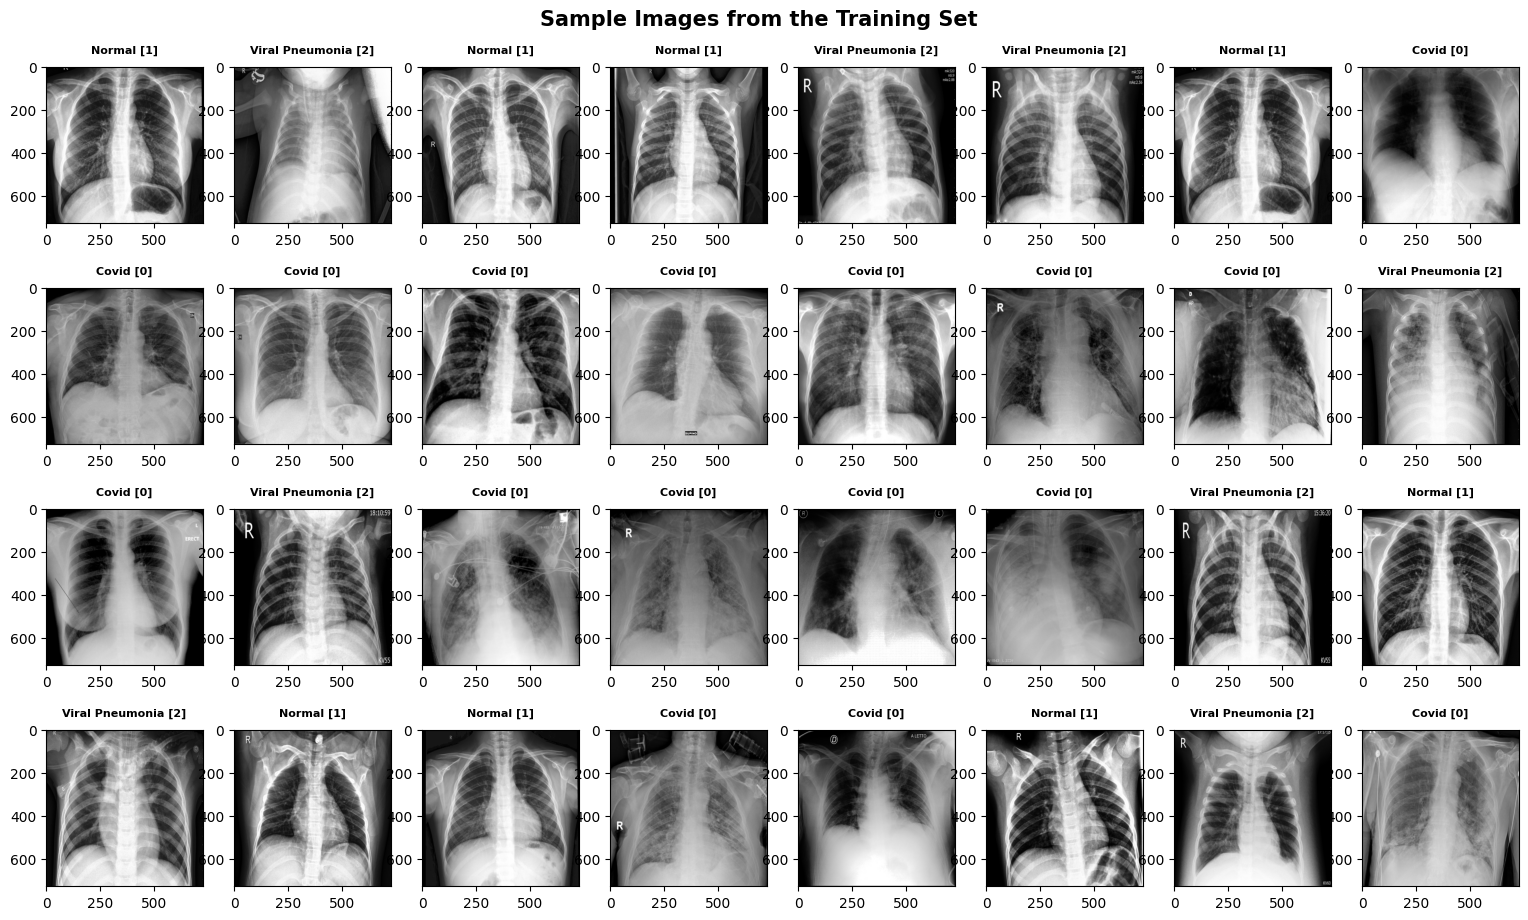

In [12]:
# display batch images in train set
train_iter = iter(train_loader)
images, labels = next(train_iter)
label_names = train_loader.dataset.classes
DatasetHandler.img_show('Sample Images from the Training Set', images, label_names, labels)

In [13]:
# check test_loader with dataframe
df_test = pd.DataFrame(test_loader.dataset.imgs, columns=['images_path', 'labels'])
print(f'test shape: {df_test.shape}')
df_test.head()

test shape: (66, 2)


,images_path,labels
0,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
1,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
2,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
3,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0
4,drive/MyDrive/Colab Notebooks/data/Covid19-dat...,0


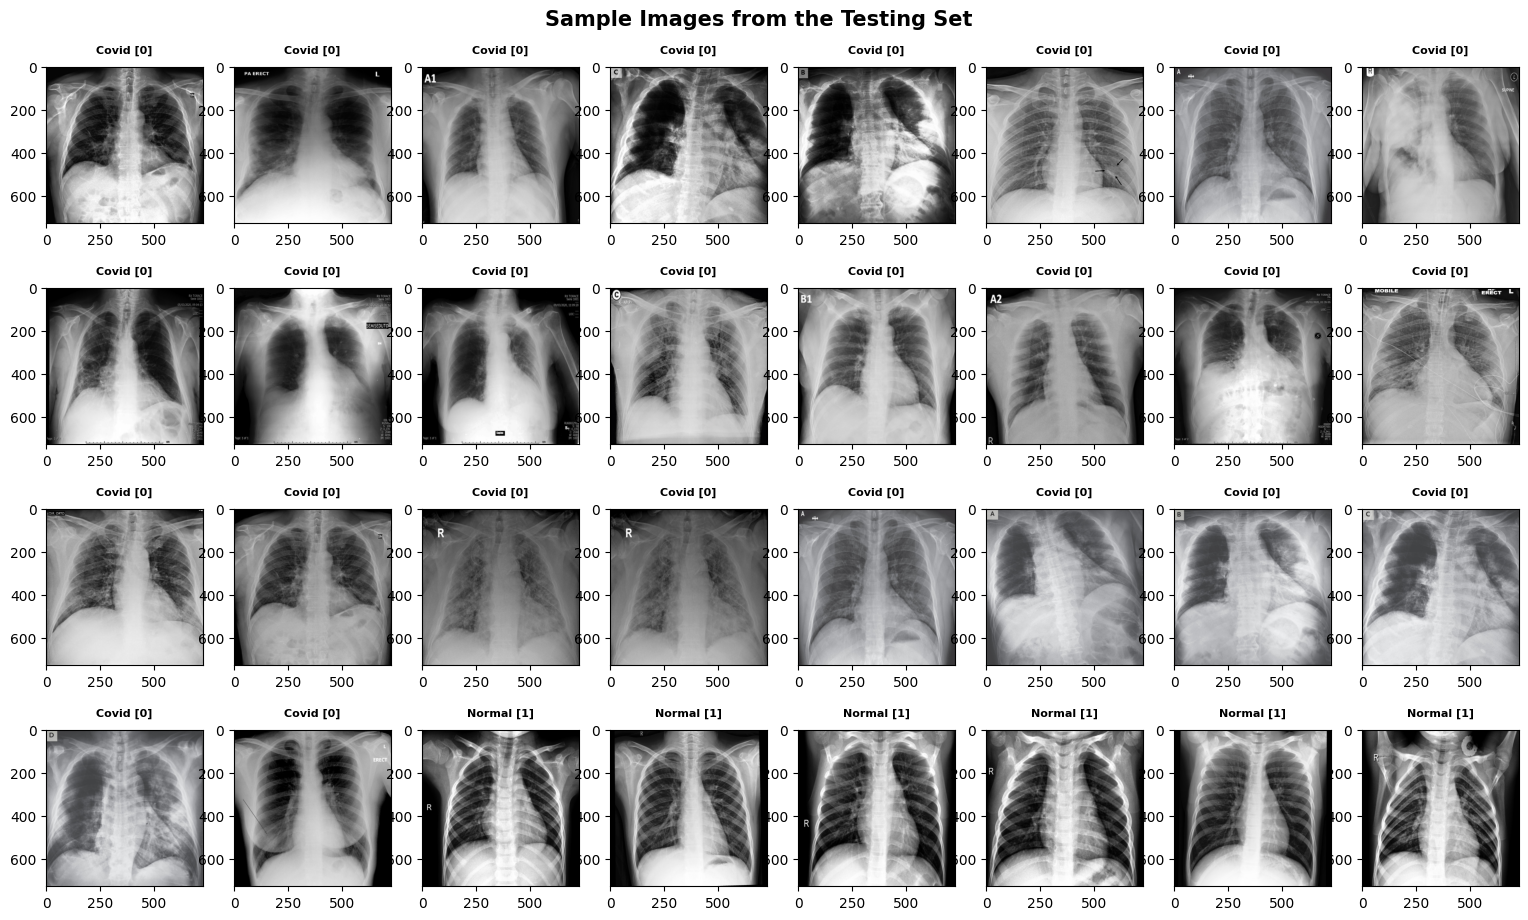

In [14]:
# display batch images in test set
test_iter = iter(test_loader)
images, labels = next(test_iter)
label_names = test_loader.dataset.classes
DatasetHandler.img_show('Sample Images from the Testing Set', images, label_names, labels)

### **Build Model**

In [43]:
# create architecture model
class CNN(torch.nn.Module):
    # Constructor
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0)
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=0)
        self.conv3 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0)
        self.drop = torch.nn.Dropout2d(p=0.2)
        self.fc = torch.nn.Linear(in_features=178 * 178 * 24, out_features=NUM_CLASSES)

    def forward(self, x):
        x = torch.nn.functional.relu(self.pool(self.conv1(x)))
        x = torch.nn.functional.relu(self.pool(self.conv2(x)))
        x = torch.nn.functional.relu(self.drop(self.conv3(x)))
        x = torch.nn.functional.dropout(x, training=self.training)
        x = x.view(-1, 178 * 178 * 24)
        x = self.fc(x)
        return torch.nn.functional.log_softmax(x, dim=1)

print("CNN Architecture is Ready!")

CNN Architecture is Ready!


In [44]:
# print the summary
model = CNN().to(DEVICE)
torchsummary.summary(model, input_size=(3, 728, 728), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 726, 726]             336
         MaxPool2d-2         [-1, 12, 363, 363]               0
            Conv2d-3         [-1, 12, 361, 361]           1,308
         MaxPool2d-4         [-1, 12, 180, 180]               0
            Conv2d-5         [-1, 24, 178, 178]           2,616
         Dropout2d-6         [-1, 24, 178, 178]               0
            Linear-7                    [-1, 3]       2,281,251
Total params: 2,285,511
Trainable params: 2,285,511
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.07
Forward/backward pass size (MB): 86.82
Params size (MB): 8.72
Estimated Total Size (MB): 101.60
----------------------------------------------------------------


In [45]:
# create model builder
class ModelBuilder:
  def __init__(self, model, save_weights=False, filename='model.pt'):
    self.model = model
    self.history = []
    self.save_weights = save_weights
    self.filename = filename
    self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    self.loss_func = torch.nn.CrossEntropyLoss()

  def clean_memory(self):
    torch.cuda.empty_cache()
    gc.collect()

  def fit(self, train_loader, test_loader):
    for epoch in range(EPOCHS):
      print(f'Epoch {epoch+1}/{EPOCHS}')

      total_loss_train = 0
      total_loss_test = 0
      y_pred_train, y_actual_train = [], []
      y_pred_test, y_actual_test = [], []

      format = '{n_fmt}/{total_fmt} [{bar}] {rate_fmt}{postfix}'
      with tqdm(total=len(train_loader), bar_format=format) as progress:

        self.model.train()
        for images, labels in train_loader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          self.optimizer.zero_grad(); logits = self.model(images)
          loss = self.loss_func(logits, labels); total_loss_train += loss.item()

          y_pred_train.extend(np.argmax(logits.detach().cpu().tolist(), axis=1).tolist())
          y_actual_train.extend(labels.cpu().tolist())

          loss.backward(); self.optimizer.step(); progress.update(1)

        self.model.eval()
        for images, labels in test_loader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          self.optimizer.zero_grad(); logits = self.model(images)
          loss = self.loss_func(logits, labels); total_loss_test += loss.item()

          y_pred_test.extend(np.argmax(logits.detach().cpu().tolist(), axis=1).tolist())
          y_actual_test.extend(labels.cpu().tolist())

        self.history.append({
          'loss':         total_loss_train/len(train_loader),
          'accuracy':     accuracy_score(y_pred_train, y_actual_train),
          'val_loss':     total_loss_test/len(test_loader),
          'val_accuracy': accuracy_score(y_pred_test, y_actual_test)
        })

        progress.set_postfix(self.history[-1], refresh=False)
        self.clean_memory()

  def predict(self, image):
    self.model.eval()
    datasetHandler = DatasetHandler()
    features_image = datasetHandler.load_image(image)
    logits = self.model(features_image.to(DEVICE))
    index = logits.detach().cpu().numpy().argmax()
    return CLASSES[index]

  def save(self, path='model.pt'):
    torch.save(self.model.state_dict(), path)
    print('Saving Model Successfully')

  def load(self, path='model.pt'):
    self.model.load_state_dict(torch.load(path))

builder = ModelBuilder(model=model)
builder.fit(train_loader, test_loader)

Epoch 1/15


8/8 [██████████]  2.56s/it, loss=3.79, accuracy=0.442, val_loss=1.19, val_accuracy=0.561


Epoch 2/15


8/8 [██████████]  2.37s/it, loss=0.501, accuracy=0.801, val_loss=0.339, val_accuracy=0.788


Epoch 3/15


8/8 [██████████]  2.38s/it, loss=0.178, accuracy=0.912, val_loss=0.453, val_accuracy=0.894


Epoch 4/15


8/8 [██████████]  2.56s/it, loss=0.134, accuracy=0.956, val_loss=0.299, val_accuracy=0.879


Epoch 5/15


8/8 [██████████]  2.37s/it, loss=0.0634, accuracy=0.976, val_loss=0.309, val_accuracy=0.848


Epoch 6/15


8/8 [██████████]  2.43s/it, loss=0.0435, accuracy=0.98, val_loss=0.425, val_accuracy=0.894


Epoch 7/15


8/8 [██████████]  2.53s/it, loss=0.0216, accuracy=0.992, val_loss=0.31, val_accuracy=0.924


Epoch 8/15


8/8 [██████████]  2.37s/it, loss=0.0229, accuracy=0.992, val_loss=0.986, val_accuracy=0.879


Epoch 9/15


8/8 [██████████]  2.37s/it, loss=0.0315, accuracy=0.988, val_loss=0.444, val_accuracy=0.909


Epoch 10/15


8/8 [██████████]  2.55s/it, loss=0.0147, accuracy=0.996, val_loss=0.668, val_accuracy=0.924


Epoch 11/15


8/8 [██████████]  2.35s/it, loss=0.0328, accuracy=0.996, val_loss=0.36, val_accuracy=0.894


Epoch 12/15


8/8 [██████████]  2.33s/it, loss=0.0138, accuracy=0.996, val_loss=0.501, val_accuracy=0.909


Epoch 13/15


8/8 [██████████]  2.51s/it, loss=0.0293, accuracy=0.996, val_loss=0.394, val_accuracy=0.909


Epoch 14/15


8/8 [██████████]  2.29s/it, loss=0.00626, accuracy=1, val_loss=0.391, val_accuracy=0.879


Epoch 15/15


8/8 [██████████]  2.33s/it, loss=0.00528, accuracy=0.996, val_loss=0.592, val_accuracy=0.924


In [46]:
# convert to dataframe
history = pd.DataFrame(builder.history)
history

,loss,accuracy,val_loss,val_accuracy
0,3.791473,0.442231,1.193621,0.560606
1,0.500658,0.800797,0.338603,0.787879
2,0.177622,0.912351,0.453176,0.893939
3,0.133550,0.956175,0.299129,0.878788
4,0.063360,0.976096,0.308526,0.848485
5,0.043542,0.980080,0.425044,0.893939
6,0.021633,0.992032,0.309680,0.924242
7,0.022873,0.992032,0.985550,0.878788
8,0.031532,0.988048,0.444390,0.909091
9,0.014693,0.996016,0.667717,0.924242


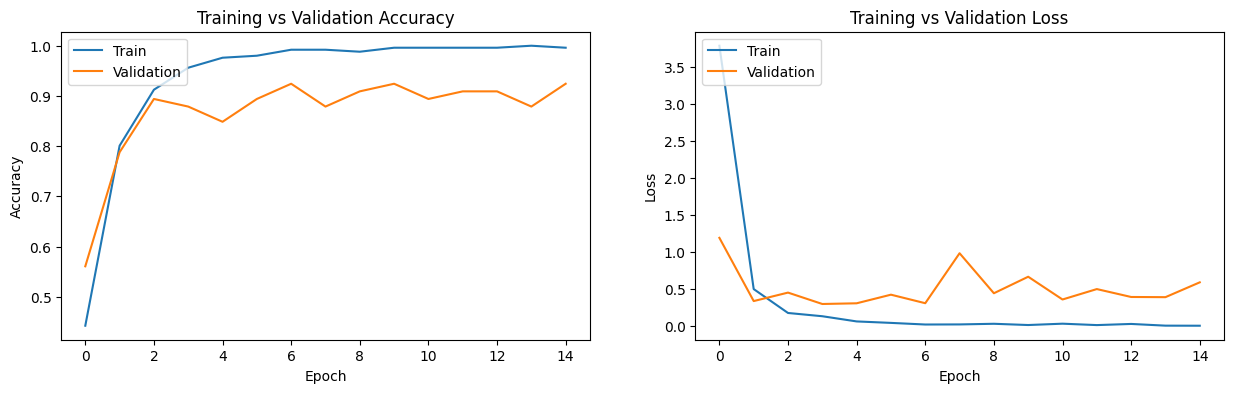

In [47]:
plt.figure(figsize=(15, 4))
# Subplot for Training vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history['accuracy'])
plt.plot(range(EPOCHS), history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot for Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history['loss'])
plt.plot(range(EPOCHS), history['val_loss'])
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### **Testing Save & Load Model**

In [48]:
# save model
builder.save()
del builder
del model

Saving Model Successfully


In [49]:
# load model
new_builder = ModelBuilder(CNN().to(DEVICE))
new_builder.load()

<ipython-input-45-3aaaafbf27c3>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [50]:
# test again with test loader
predictions = []
labels = []
for i, (image_path, label) in enumerate(test_loader.dataset.imgs):
  predictions.append(new_builder.predict(image_path))
  labels.append(CLASSES[label])

print((np.array(predictions) == np.array(labels)).sum(), '/', len(predictions))

report = classification_report(labels, predictions, target_names=CLASSES)
print(report)

61 / 66
                 precision    recall  f1-score   support

          Covid       0.93      0.96      0.94        26
         Normal       0.87      1.00      0.93        20
Viral Pneumonia       1.00      0.80      0.89        20

       accuracy                           0.92        66
      macro avg       0.93      0.92      0.92        66
   weighted avg       0.93      0.92      0.92        66



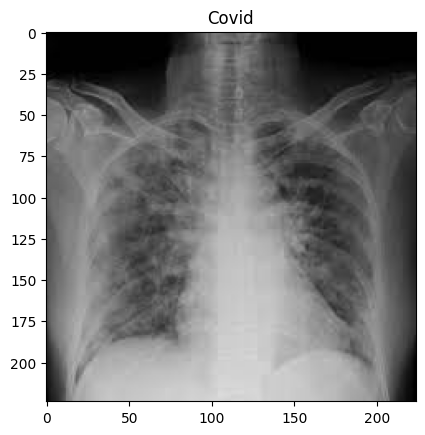

In [51]:
# testing with other image from internet
label = new_builder.predict('sample-covid.jpeg')
plt.imshow(cv2.cvtColor(cv2.imread('sample-covid.jpeg'), cv2.COLOR_BGR2RGB))
plt.title(label)
plt.show()